In [4]:
# cluster_reader.ipynb
# Authors: Stephan Meighen-Berger
# Loads and analyzes the results from dm_source_batch.py

In [5]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import UnivariateSpline
from scipy.optimize import root_scalar

In [6]:
# picture path
PICS = '../pics/'

In [7]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [8]:
# Plotting standards
std_size = 6.
fontsize = 20.
lw=1.
h_length=1.
mark_s = 10
export_dpi = 100
# params
mag_fit = 1.
colors = ['#fef0d9', '#fdcc8a', '#fc8d59', '#e34a33', '#b30000']
alphas = [0.2, 0.4, 0.6, 0.8, 1.]
# labels_mass = ['1\;TeV', '100\;TeV', '10\;PeV', '30\;TeV']
linest = ['-', '--', '-.', ':']

In [83]:
# Run parameters
m_eborders = np.logspace(4., 8., 41)
m_ewidths = np.diff(m_eborders)
m_egrid = np.sqrt(m_eborders[1:]*m_eborders[:-1])
minimal_resolution = 0.2
ra_grid = np.arange(0., 360., minimal_resolution)
decl_grid = np.arange(0., 10., minimal_resolution)
flux_scan = np.logspace(-40, -10, 100)  # Fluxes to test
ide_scan = [0, 5, 10, 15, 18, 20, 25, 30, 35, 39]  # energy ids to test

In [123]:
pop_store = []
set_list = [1, 10, 100]
for set_id in set_list:
    pre_string = "..\\data\\cluster_sim\\set_%d\\results\\" % set_id
    job_range = 1000 * set_id
    for job_id in range(job_range)[(set_id - 1) * 1000:]:
        job_id += 1
        parsed_val = divmod(job_id, 1000)
        population = parsed_val[0] + 1
        parsed_val_2 = divmod(parsed_val[1], 100)
        ide_val = parsed_val_2[0]
        idf_val = parsed_val_2[1]
        ide_scan = [0, 5, 10, 15, 18, 20, 25, 30, 35, 39]  # energy ids to test
        ide = ide_scan[ide_val]
        file_name = "cl_lim_res_pop_%d_ide_%d_idf_%d.p" % (
            population, ide, idf_val
        )
        pop_store.append(pickle.load(open(pre_string + file_name, "rb")))
pop_store.insert(0, 0.)
pop_store = np.array(pop_store)

In [124]:
# Parsing
pops_lens = 3
pops = [1, 10, 100]
pop_dic = {}
for pop_id in range(pops_lens):
    pop = pops[pop_id]
    pop_dic[pop] = (pop_store[
        (pop_id)*1000:(pop_id+1)*1000
    ].reshape(len(ide_scan), (len(flux_scan))))

In [125]:
# Fetching the flux values
plot_grid_y = []
for pop in pops:
    tmp_plot_grid = []
    for ide in range(len(ide_scan)):
        spline = UnivariateSpline(flux_scan,
            pop_dic[pop][ide], k=1, s=0,
        )
        def root_flux(flux):
            return (spline(10**flux) - 0.9)
        sol = root_scalar(root_flux, bracket=[-40, -10], method='brentq')
        value = sol.root
        tmp_plot_grid.append(value)
    plot_grid_y.append(tmp_plot_grid)

In [126]:
# Smoothing function
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

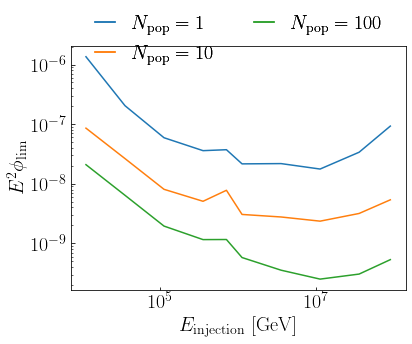

In [127]:
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
# ---------------------------------------------
# Plotting
for pop in range(len(pops)):
    ax1.plot(
        m_egrid[ide_scan],
        smooth(10**np.array(plot_grid_y[pop]) * m_egrid[ide_scan]**2, 1),
        label=r'$ N_\mathrm{pop}=%d $' %pops[pop],
    )
# ---------------------------------------------
# Axis options
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlabel(r"$E_\mathrm{injection}\;[\mathrm{GeV}]$", fontsize=fontsize)
ax1.set_ylabel(r"$E^2 \phi_\mathrm{lim}$", fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
# ---------------------------------------------
# Legend
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h, l, loc=9, bbox_to_anchor=(0.5, +1.2),
                    ncol=2, fontsize=fontsize, handlelength=h_length,
                    fancybox=True, frameon=False)
ax1.add_artist(lgd1)
# ---------------------------------------------
# Showing the image
plt.show()
# ---------------------------------------------
# Storing the image
figure.savefig(PICS + "source_limits.png",
                bbox_inches='tight', dpi=export_dpi)